# Risk & Reward from 14h to 14h30 - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-10-21 14:10:00,1927.5,1933.0,1918.7,1922.0,16658
2025-10-21 14:15:00,1922.0,1927.5,1919.2,1921.5,8361
2025-10-21 14:20:00,1921.5,1926.0,1902.9,1906.7,16009


In [15]:
def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1400]
    return tick.max()

def cal_high_after(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute > 1400]
    return tick.max()

def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1400]
    return tick.min()

def cal_low_after(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute > 1400]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]


def get_2pm_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1400]
    if not tick.empty:
        return tick[0]

In [53]:
data["tmp_High"] = data["High"]
data["tmp_Low"] = data["Low"]
data["_2pm_price"] = data["Close"]
data["day_Close"] = data["Close"]
day_data = data.resample("D").agg({
        'tmp_High': cal_high_before,
        'tmp_Low': cal_low_before,
        '_2pm_price': get_2pm_price,
        'High': cal_high_after,
        'Low': cal_low_after,
        'day_Close': cal_last
    })
day_data.dropna(subset=['day_Close'], inplace=True)

In [54]:
day_data["current_return"] = (day_data["_2pm_price"] - day_data["day_Close"].shift(1)) * 1000 / day_data["day_Close"].shift(1)
day_data["current_momentum"] = (day_data["_2pm_price"] - day_data["day_Close"].shift(1)) * 10  / (day_data["tmp_High"] - day_data["tmp_Low"])

In [55]:
day_data

,tmp_High,tmp_Low,_2pm_price,High,Low,day_Close,current_return,current_momentum
Date,,,,,,,,
2020-11-02,903.0,895.4,901.5,907.0,896.6,904.0,NaN,NaN
2020-11-03,910.8,903.7,906.3,910.4,904.1,908.3,2.544248,3.239437
2020-11-04,917.2,906.7,916.7,917.9,910.2,912.3,9.248046,8.000000
2020-11-05,919.9,912.4,916.6,917.8,910.0,910.2,4.713362,5.733333
2020-11-06,912.0,903.3,908.6,912.7,907.5,908.3,-1.757855,-1.839080
...,...,...,...,...,...,...,...,...
2025-10-15,2034.0,2013.5,2021.6,2031.0,2015.1,2022.0,3.673915,3.609756
2025-10-16,2026.0,2011.3,2013.5,2015.8,2009.0,2012.7,-4.203759,-5.782313
2025-10-17,2017.5,1982.1,1986.9,1988.3,1960.0,1968.0,-12.818602,-7.288136


In [56]:
day_data["up"] = day_data["High"] - day_data["_2pm_price"]
day_data["down"] = day_data["_2pm_price"] - day_data["Low"]
day_data.dropna(inplace=True)

In [60]:
day_data['current_return_group'] = pd.qcut(day_data.current_return, 20)

In [61]:
day_data['current_momentum_group'] = pd.qcut(day_data.current_momentum, 20)

## Up Analytics

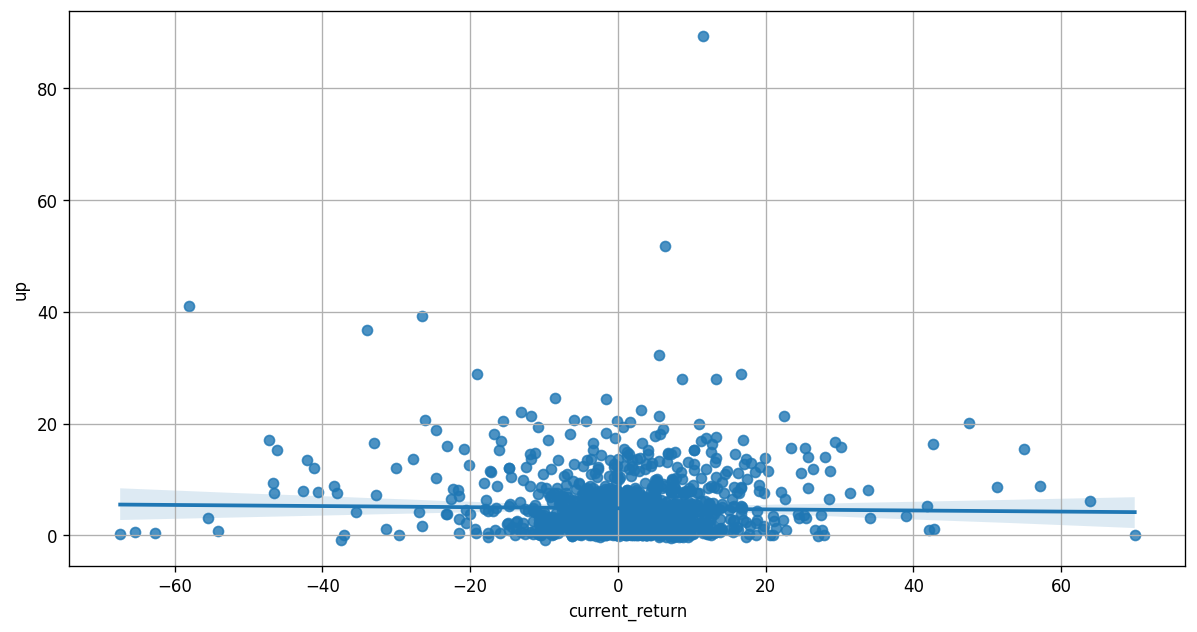

In [69]:
sns.regplot(x=day_data['current_return'], y=day_data['up'])
plt.grid(True)

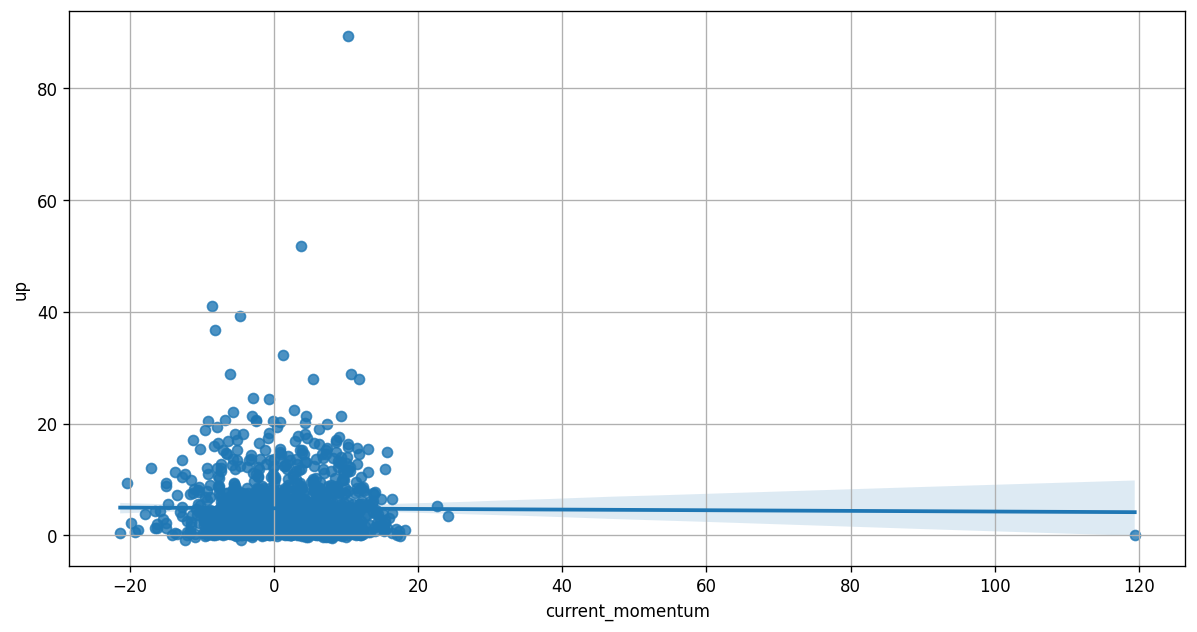

In [70]:
sns.regplot(x=day_data['current_momentum'], y=day_data['up'])
plt.grid(True)

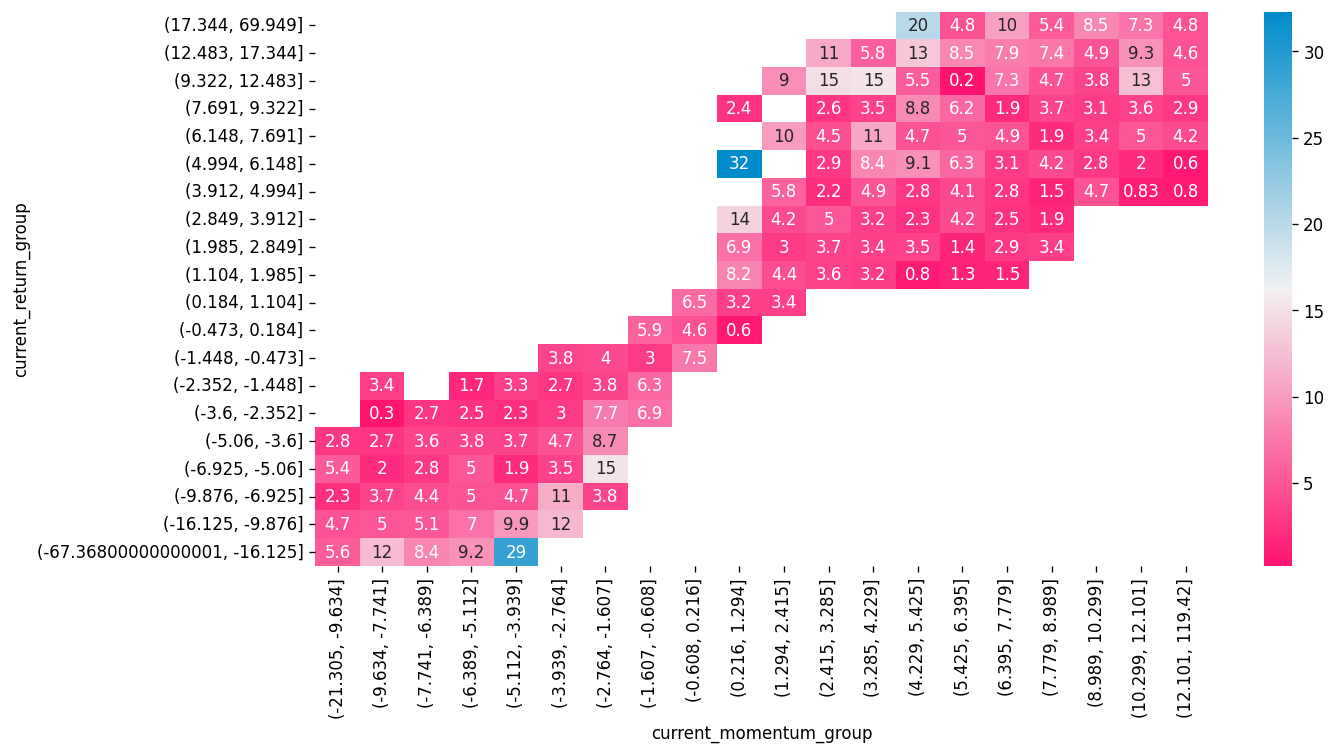

In [62]:
irs = day_data.groupby(['current_return_group', 'current_momentum_group'])[['up']].mean().reset_index()
irs_pivot = irs.pivot(index='current_return_group', columns='current_momentum_group', values='up').sort_index(ascending=False)
sns.heatmap(
    irs_pivot,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="light", as_cmap=True),
    annot=True);

## Down Analytics

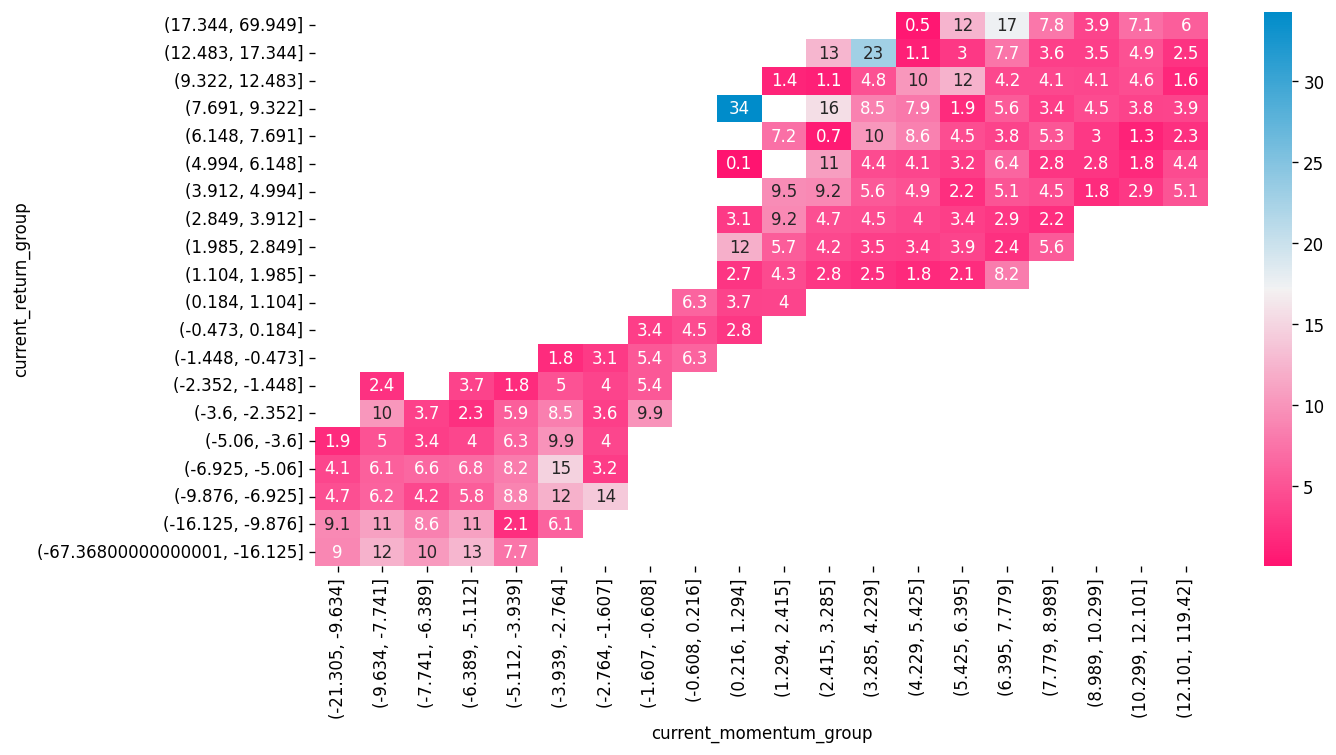

In [63]:
irs = day_data.groupby(['current_return_group', 'current_momentum_group'])[['down']].mean().reset_index()
irs_pivot = irs.pivot(index='current_return_group', columns='current_momentum_group', values='down').sort_index(ascending=False)
sns.heatmap(
    irs_pivot,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="light", as_cmap=True),
    annot=True);

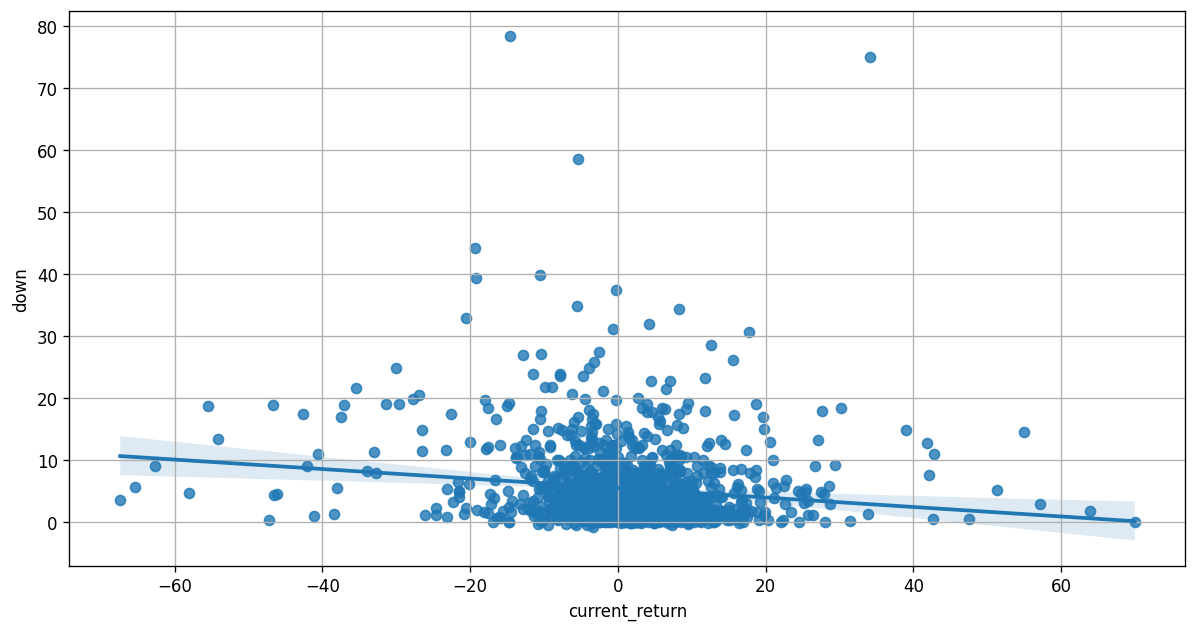

In [68]:
sns.regplot(x=day_data['current_return'], y=day_data['down'])
plt.grid(True)

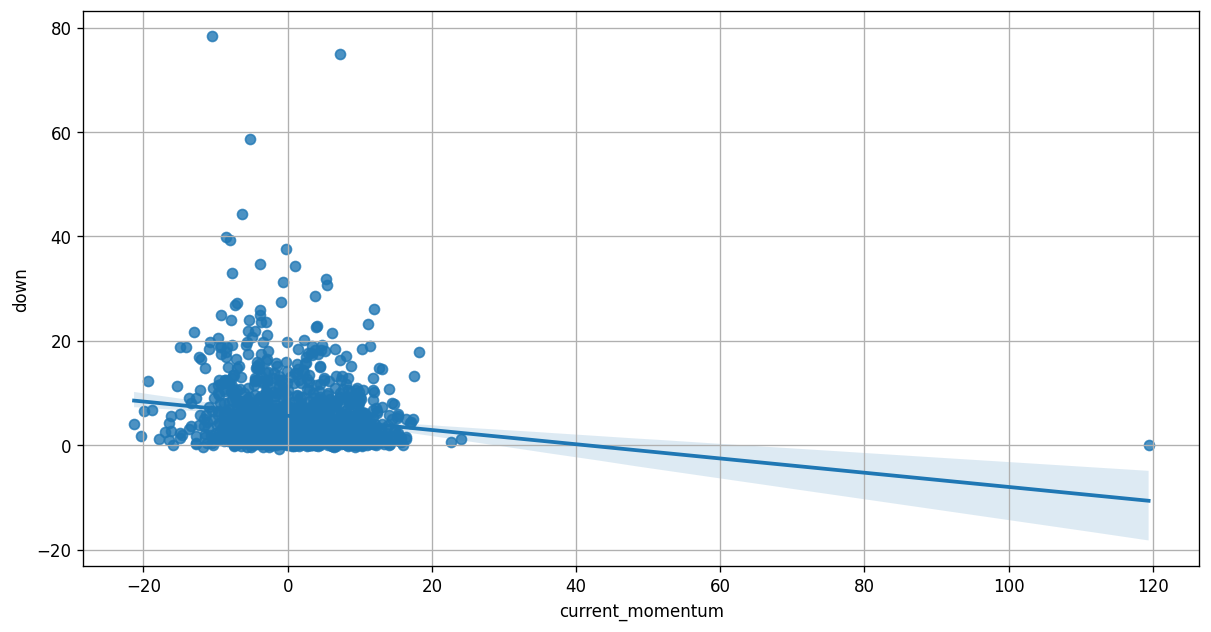

In [67]:
sns.regplot(x=day_data['current_momentum'], y=day_data['down'])
plt.grid(True)